In [22]:
from itertools import count

from botocore.compat import from_pairs
# 简单地说，机器学习就是做出预测。
# 根据病人的临床病史，我们可能想预测他们在下一年心脏病发作的概率。在飞机喷气发动机的异常检测中，我们想要评估一组发动机读数为正常运行情况的概率有多大。
# 在强化学习中，我们希望智能体（agent）能在一个环境中智能地行动。这意味着我们需要考虑在每种可行的行为下获得高奖励的概率。
# 当我们建立推荐系统时，我们也需要考虑概率。例如，假设我们为一家大型在线书店工作，我们可能希望估计某些用户购买特定图书的概率。
# 为此，我们需要使用概率学。有完整的课程、专业、论文、职业、甚至院系，都致力于概率学的工作。
# 所以很自然地，我们在这部分的目标不是教授整个科目。
# 相反，我们希望教给读者基础的概率知识，使读者能够开始构建第一个深度学习模型，以便读者可以开始自己探索它。

%matplotlib inline
import torch
from torch.distributions import multinomial
from d2l import torch as d2l

# 在统计学中，我们把从概率分布中抽取样本的过程称为抽样（sampling）。
# 笼统来说，可以把分布（distribution）看作对事件的概率分配，稍后我们将给出的更正式定义。
# 将概率分配给一些离散选择的分布称为多项分布（multinomial distribution）。
# 为了抽取一个样本，即掷骰子，我们只需传入一个概率向量。
# 输出是另一个相同长度的向量：它在索引i处的值是采样结果中i出现的次数。
fair_probs = torch.ones(6) / 6
print("fair_probs:", fair_probs)
# n=1 表示我们要从这 6 个面中进行一次采样
multinomial.Multinomial(1, fair_probs).sample()

fair_probs: tensor([0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667])


tensor([0., 0., 0., 0., 1., 0.])

In [18]:
# 在估计一个骰子的公平性时，我们希望从同一分布中生成多个样本。
# 如果用Python的for循环来完成这个任务，速度会慢得惊人。
# 因此我们使用深度学习框架的函数同时抽取多个样本，得到我们想要的任意形状的独立样本数组。
multinomial.Multinomial(10, fair_probs).sample()

# 在 PyTorch 中，torch.distributions.Multinomial 是用于表示**多项分布（Multinomial Distribution）**的一个类，它用于从一个多项分布中抽样。
# 多项分布是一个常见的离散概率分布，描述了进行多次实验时，每种可能结果的发生次数。

# 多项分布（Multinomial Distribution）：是对多次伯努利试验的推广。
# 假设你有 n 次试验，每次试验有 k 个可能的结果，每个结果的发生概率分别为 p_1, p_2, ..., p_k，这些结果的概率总和为 1。
# 在多项分布中，进行 n 次试验后，每个结果发生的次数服从多项分布。
# 独立的试验次数和结果分类：在多项分布中，每次试验都是独立的，结果可以有多种分类。比如，掷骰子多次，或者从多个可能的类别中随机选择多次。

# torch.distributions.Multinomial(total_count=1, probs=None, logits=None)
# total_count：表示试验的总次数，即进行多少次抽样。默认是 1 次。
# probs：一个张量，表示每种可能结果的概率。这个张量的元素必须非负且和为 1。
# logits：这个参数可以用来替代 probs

tensor([0., 3., 4., 1., 2., 0.])

In [31]:
# 现在我们知道如何对骰子进行采样，我们可以模拟1000次投掷。
# 然后，我们可以统计1000次投掷后，每个数字被投中了多少次。
# 具体来说，我们计算相对频率，以作为真实概率的估计。

# 将结果存储为32位浮点数以进行除法
counts = multinomial.Multinomial(1000, fair_probs).sample()
counts / 1000 # 相对频率作为估计值

# 因为我们是从一个公平的骰子中生成的数据，我们知道每个结果都有真实的概率 16 ，大约是0.167，所以上面输出的估计值看起来不错。

tensor([0.1810, 0.1480, 0.1810, 0.1590, 0.1770, 0.1540])

counts:  tensor([[2., 2., 1., 1., 3., 1.],
        [1., 3., 2., 2., 0., 2.],
        [0., 3., 4., 2., 0., 1.],
        ...,
        [2., 0., 1., 2., 2., 3.],
        [2., 3., 2., 0., 2., 1.],
        [0., 0., 1., 4., 3., 2.]])
cum_counts:  tensor([[  2.,   2.,   1.,   1.,   3.,   1.],
        [  3.,   5.,   3.,   3.,   3.,   3.],
        [  3.,   8.,   7.,   5.,   3.,   4.],
        ...,
        [830., 835., 819., 872., 827., 797.],
        [832., 838., 821., 872., 829., 798.],
        [832., 838., 822., 876., 832., 800.]])


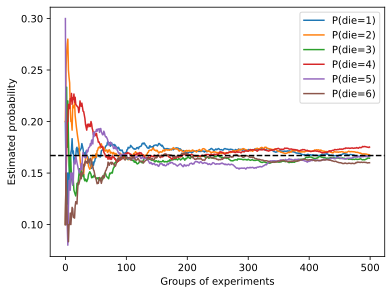

In [34]:
# 我们也可以看到这些概率如何随着时间的推移收敛到真实概率。让我们进行500组实验，每组抽取10个样本。
counts = multinomial.Multinomial(10, fair_probs).sample((500,))
print("counts: ", counts)
cum_counts = counts.cumsum(dim=0)
print("cum_counts: ", cum_counts)
estimates = cum_counts / cum_counts.sum(dim=1, keepdims=True)
d2l.set_figsize((6, 4.5))
for i in range(6):
    d2l.plt.plot(estimates[:, i].numpy(), label=("P(die=" + str(i + 1) + ")"))
d2l.plt.axhline(y=0.167, color='black', linestyle='dashed')
d2l.plt.gca().set_xlabel('Groups of experiments')
d2l.plt.gca().set_ylabel('Estimated probability')
d2l.plt.legend();

In [ ]:
# 每条实线对应于骰子的6个值中的一个，并给出骰子在每组实验后出现值的估计概率。
# 当我们通过更多的实验获得更多的数据时，这6条实体曲线向真实概率收敛。

In [ ]:
# 概率论公理
# 在处理骰子掷出时，我们将集合S = {1, 2, 3, 4, 5, 6} 称为样本空间（sample space）或结果空间（outcome space），其中每个元素都是结果（outcome）。
# 事件（event）是一组给定样本空间的随机结果。例如，“看到5”（{5}）和“看到奇数”（{1, 3, 5}）都是掷出骰子的有效事件。
# 注意，如果一个随机实验的结果在A中，则事件A已经发生。
# 也就是说，如果投掷出3点，因为3 ∈ {1, 3, 5}，我们可以说，“看到奇数”的事件发生了。
# 概率（probability）可以被认为是将集合映射到真实值的函数。
# 在给定的样本空间S中，事件A的概率，表示为P (A)，满足以下属性：
# 1. 对于任何事件A，其概率为非负值，即P (A) ≥ 0。
# 2. 整个样本空间的概率为1，即P (S) = 1。
# 对于互斥（mutually exclusive）事件（对于所有i ̸ = j都有A i ∩ A j = ∅）的任意一个可数序列A 1 , A 2 , . . .，
# 序列中任意一个事件发生的概率等于它们各自发生的概率之和。


# 随机变量
# 在我们掷骰子的随机实验中，我们引入了随机变量（random variable）的概念。
# 随机变量几乎可以是任何数量，并且它可以在随机实验的一组可能性中取一个值。
# 考虑一个随机变量X，其值在掷骰子的样本空间S = {1, 2, 3, 4, 5, 6}中。
# 我们可以将事件“看到一个5”表示为{X = 5}或X = 5，其概率表示为P ({X =5})或P (X = 5)。通过P (X = a)，我们区分了随机变量X和X可以采取的值（例如a）。
# 然而，这可能会导致繁琐的表示。为了简化符号，一方面，我们可以将P (X)表示为随机变量X上的分布（distribution）：分布告诉我们X获得某一值的概率。
# 另一方面，我们可以简单用P (a)表示随机变量取值a的概率。由于概率论中的事件是来自样本空间的一组结果，因此我们可以为随机变量指定值的可取范围。
# 例如，P (1 ≤ X ≤ 3)表示事件{1 ≤ X ≤ 3}，即{X = 1, 2, or, 3}的概率。
# 等价地，P (1 ≤ X ≤ 3)表示随机变量X从{1, 2, 3}中取值的概率。
# 请注意，离散（discrete）随机变量（如骰子的每一面）和连续（continuous）随机变量（如人的体重和身高）之间存在微妙的区别。
# 现实生活中，测量两个人是否具有完全相同的身高没有太大意义。
# 如果我们进行足够精确的测量，最终会发现这个星球上没有两个人具有完全相同的身高。
# 在这种情况下，询问某人的身高是否落入给定的区间，比如是否在1.79米和1.81米之间更有意义。
# 在这些情况下，我们将这个看到某个数值的可能性量化为密度（density）。
# 高度恰好为1.80米的概率为0，但密度不是0。在任何两个不同高度之间的区间，我们都有非零的概率。
# 在本节的其余部分中，我们将考虑离散空间中的概率。连续随机变量的概率可以参考深度学习数学附录中随机变量 42 的一节。

# 处理多个随机变量
# 很多时候，我们会考虑多个随机变量。比如，我们可能需要对疾病和症状之间的关系进行建模。
# 给定一个疾病和一个症状，比如“流感”和“咳嗽”，以某个概率存在或不存在于某个患者身上。
# 我们需要估计这些概率以及概率之间的关系，以便我们可以运用我们的推断来实现更好的医疗服务。
# 再举一个更复杂的例子：图像包含数百万像素，因此有数百万个随机变量。
# 在许多情况下，图像会附带一个标签（label），标识图像中的对象。
# 我们也可以将标签视为一个随机变量。我们甚至可以将所有元数据视为随机变量，例如位置、时间、光圈、焦距、ISO、对焦距离和相机类型。
# 所有这些都是联合发生的随机变量。当我们处理多个随机变量时，会有若干个变量是我们感兴趣的。

# 联合概率
# 第一个被称为联合概率（joint probability）P (A = a, B = b)。
# 给定任意值a和b，联合概率可以回答：A =a和B = b同时满足的概率是多少？
# 请注意，对于任何a和b的取值， P (A = a, B = b) ≤ P (A = a)。
# 这点是确定的，因为要同时发生A = a和B = b， A = a就必须发生， B = b也必须发生（反之亦然）。
# 因此， A = a和B = b同时发生的可能性不大于A = a或是B = b单独发生的可能性。

# 条件概率
# 联合概率的不等式带给我们一个有趣的比率： 0 ≤ P (A=a,B=b)/P (A=a) ≤ 1。
# 我们称这个比率为条件概率（conditional probability），并用P (B = b | A = a)表示它：它是B = b的概率，前提是A = a已发生。

# 贝叶斯定理